<a href="https://colab.research.google.com/github/khdag/ECE9309_Project_Group_15_Flight_Delay_Prediction/blob/main/Flight_Delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** Predict whether a flight will be delayed upon arrival based on pre-flight information.

**Dataset:** https://www.kaggle.com/datasets/sriharshaeedala/airline-delay/data

**Model:** Gradient Boosting Classifier.


---

**Steps:**

1.  **Load Data:** Read the CSV file using pandas.
2.  **Initial Cleaning:** Handle missing values, filter out cancelled/diverted flights (as they don't have arrival delays in the same sense).
3.  **Feature Engineering:** Create the target variable (`IS_DELAYED`). Extract useful features (e.g., hour from scheduled departure time). Select relevant columns.
4.  **Preprocessing:** Encode categorical features (like Airline).
5.  **Split Data:** Divide the data into training and testing sets.
6.  **Train Model:** Train a `GradientBoostingClassifier` on the training data.
7.  **Evaluate Model:** Assess the model's performance on the test data using relevant metrics.
8.  **Feature Importance:**  Examine feature importances provided by the model.

---

**Python Code:**

Loading data from Airline_Delay_Cause.csv...
Data loaded in 1.25 seconds.
Initial shape: (171666, 21)
Cleaning and preparing data...
Duplicates found for year/month/airport. Including 'carrier' in identifier.
Shape after dropping rows with NaN in key calculation columns: (171223, 22)
Creating lagged features...
Features initially selected for NA drop check: ['delay_proportion_lag1', 'delay_proportion_lag2', 'delay_proportion_lag3', 'delay_proportion_lag12', 'arr_flights_lag1', 'weather_ct_lag1', 'delay_prop_roll_avg3', 'month_num']
Shape before dropping NaNs from features: (171223, 31)
Shape after dropping NaNs from features: (141334, 31)
Data preparation completed in 0.56 seconds.
Encoding categorical features...
Encoding completed in 2.11 seconds.
Final feature shape: (141334, 410)
Splitting data: Training before 2022, Testing from 2022...
Train shape: X=(109832, 410), y=(109832,)
Test shape: X=(31502, 410), y=(31502,)
Training Gradient Boosting Regressor...
      Iter       Train Lo

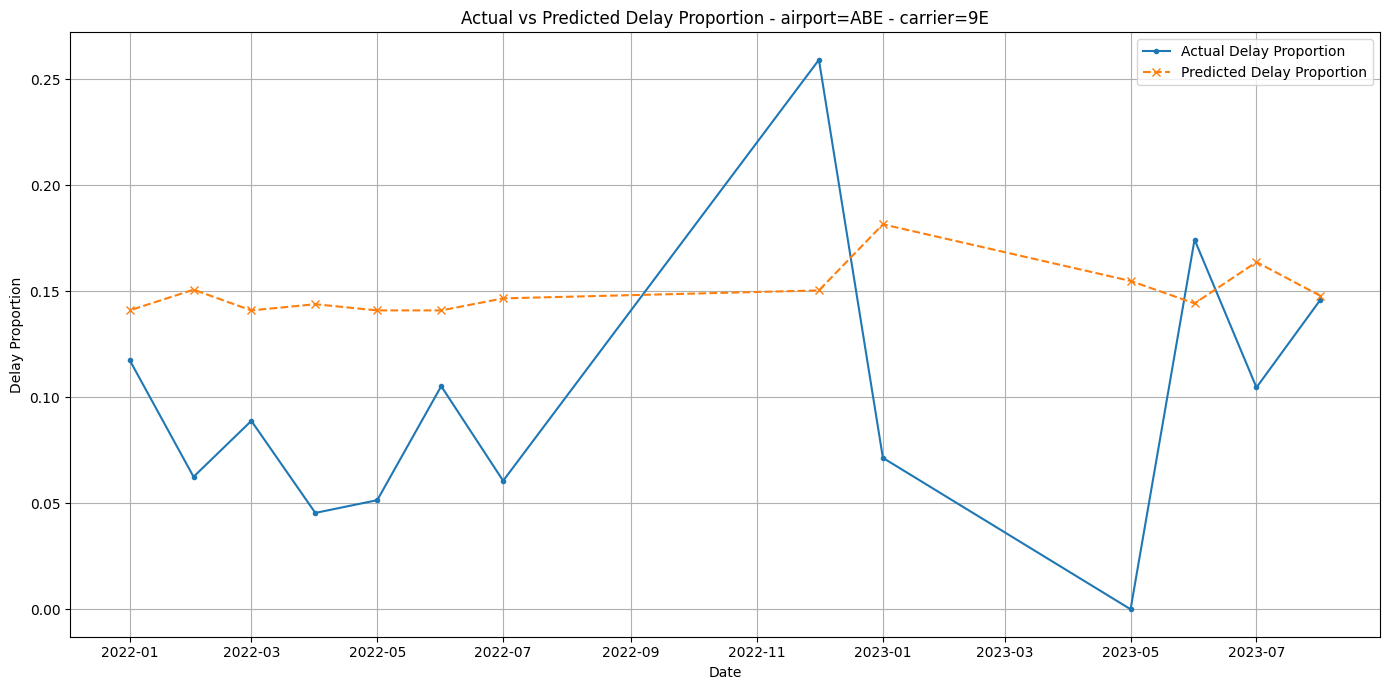

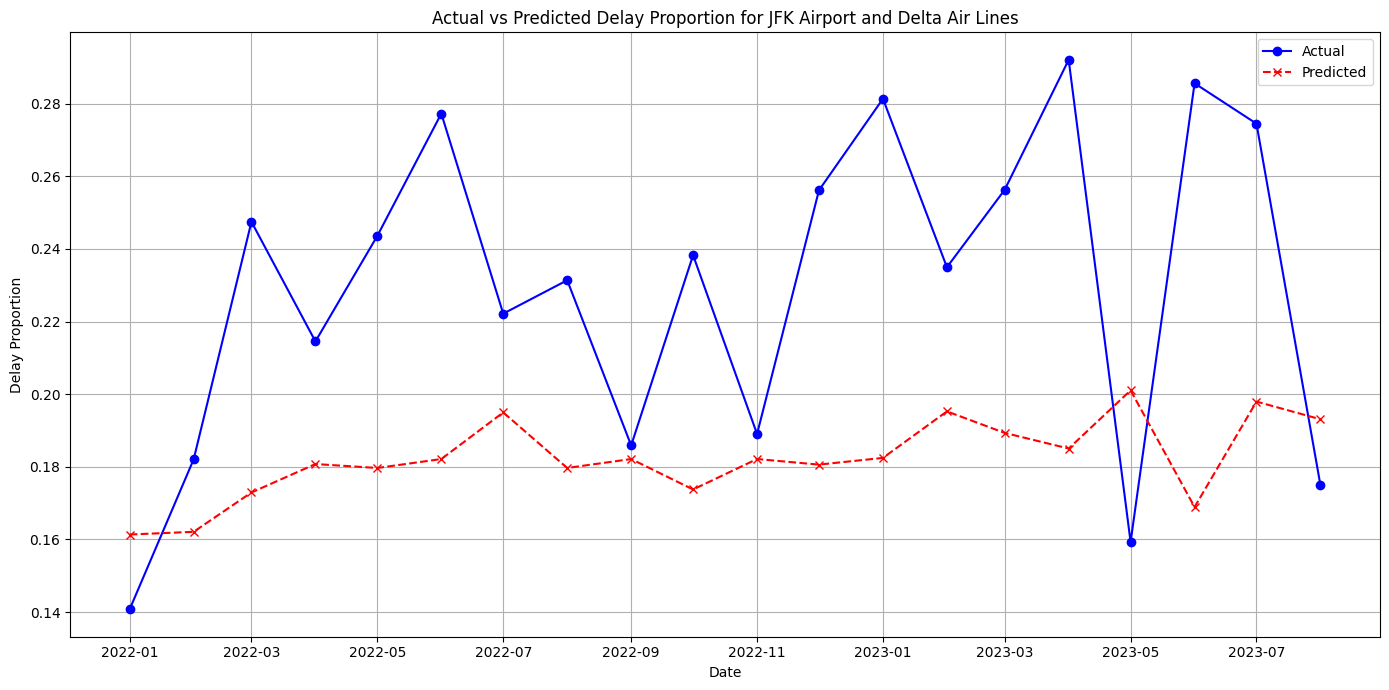

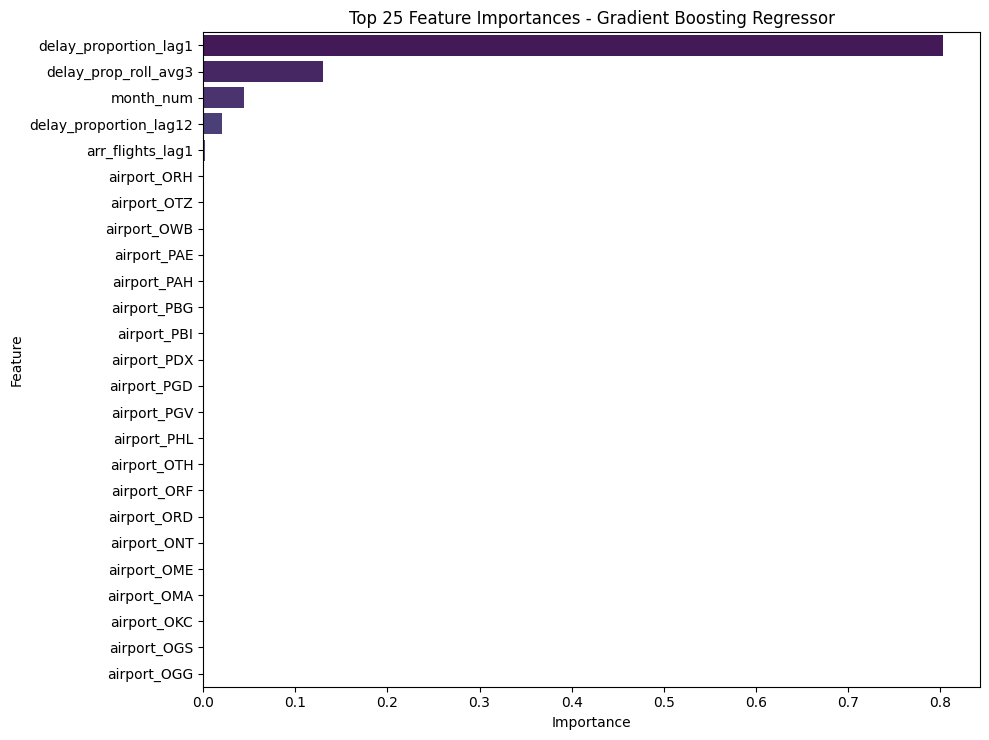

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder # For encoding categoricals
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Configuration ---
DATA_FILE = 'Airline_Delay_Cause.csv'

# Time-based split point (use data BEFORE this year for training)
# Adjust based on the actual years in your data
TRAIN_UP_TO_YEAR = 2021 # Example: Train on data up to end of 2021
TEST_START_YEAR = 2022  # Example: Test on 2022 onwards

RANDOM_STATE = 42 # For reproducibility of the model training part

# --- 1. Load Data ---
print(f"Loading data from {DATA_FILE}...")
start_time = time.time()
try:
    df = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: Data file '{DATA_FILE}' not found.")
    print("Please ensure the file exists in the correct directory.")
    exit()

print(f"Data loaded in {time.time() - start_time:.2f} seconds.")
print(f"Initial shape: {df.shape}")


# --- 2. Initial Cleaning & Preparation ---
print("Cleaning and preparing data...")
start_time = time.time()

# Create a datetime column for easier handling and sorting
# Assuming 'month' is 1-12
try:
    # Create date column ensuring year and month are integers first
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
except (ValueError, KeyError, TypeError) as e:
     print(f"Error creating date column. Ensure 'year' and 'month' columns exist and are valid integers: {e}")
     exit()


# Define the identifier columns for grouping (adjust if needed)
identifier_cols = ['airport'] # Default assumption
# Check if 'carrier' column exists and if there are duplicates suggesting finer granularity
if 'carrier' in df.columns and df.duplicated(subset=['year', 'month', 'airport']).any():
    print("Duplicates found for year/month/airport. Including 'carrier' in identifier.")
    identifier_cols = ['airport', 'carrier']
else:
     # Ensure 'airport' column exists if it's the default identifier
     if 'airport' not in df.columns:
         print("Error: Default identifier 'airport' not found in columns.")
         exit()
     print("Assuming data is aggregated per airport per month.")


# Sort data chronologically within each group (essential for lags)
df.sort_values(identifier_cols + ['date'], inplace=True)

# Handle potential missing values in key columns before calculations
cols_to_check_na = ['arr_del15', 'arr_flights']
# Ensure these columns exist before trying to drop NA
if not all(col in df.columns for col in cols_to_check_na):
    print(f"Error: Columns {cols_to_check_na} needed for calculation are missing.")
    exit()
df.dropna(subset=cols_to_check_na, inplace=True)
print(f"Shape after dropping rows with NaN in key calculation columns: {df.shape}")

# --- 3. Feature Engineering ---

# Create Target Variable: Delay Proportion
# Handle division by zero: if arr_flights is 0, proportion is 0
df['delay_proportion'] = df['arr_del15'].divide(df['arr_flights']).replace([np.inf, -np.inf], 0).fillna(0)
target = 'delay_proportion'

# Create Lagged Features (Grouped by identifier cols)
print("Creating lagged features...")
lags_to_create = [1, 2, 3, 12] # Lags for 1, 2, 3 months ago and 1 year ago
lagged_cols_data = {} # Store actual data series

# Lag the target variable
for lag in lags_to_create:
    col_name = f'{target}_lag{lag}'
    # Use try-except to handle potential issues if grouping fails (e.g., empty groups)
    try:
        lagged_cols_data[col_name] = df.groupby(identifier_cols, observed=True)[target].shift(lag)
    except KeyError as e:
        print(f"Warning: Grouping failed for lag {lag} of target. Check identifier columns. Error: {e}")
        lagged_cols_data[col_name] = pd.Series(index=df.index, dtype=float) # Assign empty series


# Lag other potentially useful features (example: total arriving flights)
# Add more lagged features as needed (e.g., lagged weather_ct, nas_ct)
if 'arr_flights' in df.columns:
    try:
        lagged_cols_data['arr_flights_lag1'] = df.groupby(identifier_cols, observed=True)['arr_flights'].shift(1)
    except KeyError as e:
        print(f"Warning: Grouping failed for lag 1 of arr_flights. Error: {e}")
        lagged_cols_data['arr_flights_lag1'] = pd.Series(index=df.index, dtype=float)
else:
    print("Warning: 'arr_flights' column not found for lagging.")

# Example: Lag weather count
if 'weather_ct' in df.columns:
    try:
         lagged_cols_data['weather_ct_lag1'] = df.groupby(identifier_cols, observed=True)['weather_ct'].shift(1)
    except KeyError as e:
        print(f"Warning: Grouping failed for lag 1 of weather_ct. Error: {e}")
        lagged_cols_data['weather_ct_lag1'] = pd.Series(index=df.index, dtype=float)
else:
    print("Warning: 'weather_ct' column not found for lagging.")


# Add lagged features to the DataFrame
for col_name, data in lagged_cols_data.items():
    df[col_name] = data

# Create Rolling Window Features (Example: 3-month rolling avg of delay proportion)
# Rolling window calculated *excluding* the current month's value
try:
    df['delay_prop_roll_avg3'] = df.groupby(identifier_cols, observed=True)[target].shift(1).rolling(window=3, min_periods=1).mean()
except KeyError as e:
    print(f"Warning: Grouping failed for rolling average calculation. Error: {e}")
    df['delay_prop_roll_avg3'] = np.nan # Assign NaN if calculation fails


# Time Features
df['month_num'] = df['date'].dt.month # Use month number directly

# --- Define Final Features for Model ---
# Start with lagged features, time features, and potentially total flights lag
features = [col for col in df.columns if 'lag' in col or 'roll' in col]
features.append('month_num')
# Optionally add year if you think there's a long-term trend not captured by lags
# features.append('year')

# Categorical features to encode
categorical_features = identifier_cols # ['airport'] or ['airport', 'carrier']

# Remove features that might be all NaN if creation failed
features = [f for f in features if f in df.columns and not df[f].isnull().all()]
print(f"Features initially selected for NA drop check: {features}")
if not features:
     print("Error: No valid features found after engineering. Check lagging/rolling steps.")
     exit()


# Keep only rows where lagged/rolled features are available (drop initial NaNs)
print(f"Shape before dropping NaNs from features: {df.shape}")
df.dropna(subset=features, inplace=True)
print(f"Shape after dropping NaNs from features: {df.shape}")
if df.empty:
    print("Error: DataFrame is empty after dropping NaNs from features. Check lags or data range.")
    exit()


print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")

# --- 4. Encoding Categorical Features ---
print("Encoding categorical features...")
start_time = time.time()

# Ensure categorical features exist
if not all(col in df.columns for col in categorical_features):
    print(f"Error: Not all categorical features {categorical_features} found in DataFrame.")
    exit()

# Use OneHotEncoder for airport/carrier codes
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # dense array

# Fit encoder on the entire relevant part of the dataframe (before splitting)
# This ensures all categories are known
try:
    encoder.fit(df[categorical_features])
except Exception as e:
    print(f"Error fitting OneHotEncoder: {e}")
    exit()


# Transform and create feature names
try:
    encoded_cats_array = encoder.transform(df[categorical_features])
    encoded_cats_feature_names = encoder.get_feature_names_out(categorical_features)
    encoded_cats_df = pd.DataFrame(encoded_cats_array, index=df.index, columns=encoded_cats_feature_names)
except Exception as e:
    print(f"Error transforming data with OneHotEncoder: {e}")
    exit()


# Combine encoded features with numerical features
# Ensure numerical features still exist after NA drop
X_numerical = df[features].copy()
X = pd.concat([X_numerical, encoded_cats_df], axis=1)

# Final list of features includes numerical + encoded categorical
final_feature_list = list(X_numerical.columns) + list(encoded_cats_feature_names)

# Ensure target column exists
if target not in df.columns:
    print(f"Error: Target column '{target}' not found.")
    exit()
y = df[target]

print(f"Encoding completed in {time.time() - start_time:.2f} seconds.")
print(f"Final feature shape: {X.shape}")

# --- 5. Time-Based Splitting ---
print(f"Splitting data: Training before {TEST_START_YEAR}, Testing from {TEST_START_YEAR}...")

# Use the boolean conditions on the original df index before encoding
# Make sure 'year' column exists
if 'year' not in df.columns:
    print("Error: 'year' column missing, cannot perform time-based split.")
    exit()

train_indices = df[df['year'] <= TRAIN_UP_TO_YEAR].index
test_indices = df[df['year'] >= TEST_START_YEAR].index


# Check if indices exist in the final feature matrix X
train_indices = train_indices.intersection(X.index)
test_indices = test_indices.intersection(X.index)

if train_indices.empty or test_indices.empty:
    print("Warning: Train or test indices are empty after intersection with features index.")
    print("Check data range, split years, or NaN handling during feature engineering.")
    # Decide whether to exit or continue, depending on requirements
    # exit() # Uncomment to stop if sets are empty

# Proceed only if both sets have data after intersection
if not train_indices.empty and not test_indices.empty:
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]

    # Verify the split
    print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test shape: X={X_test.shape}, y={y_test.shape}")
else:
    print("Error: Cannot proceed with empty train or test set after index intersection.")
    exit()


# --- 6. Train Model ---
print("Training Gradient Boosting Regressor...")
start_time = time.time()

gb_regressor = GradientBoostingRegressor(
    n_estimators=10,      # Number of trees (tune this)
    learning_rate=0.05,     # Step size (tune this)
    max_depth=3,           # Tree depth (tune this)
    subsample=0.5,         # Fraction of samples per tree
    random_state=RANDOM_STATE,
    loss='squared_error',  # Use 'absolute_error' for MAE-like loss, or 'huber'
    verbose=1              # Show progress
)

# Train the model
gb_regressor.fit(X_train, y_train)

print(f"Model training completed in {time.time() - start_time:.2f} seconds.")

# --- 7. Evaluate Model ---
print("Evaluating model performance...")
start_time = time.time()

# Predict on the test set
y_pred = gb_regressor.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
# Use np.sqrt for RMSE for clarity or keep squared=False
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation Results (Test Set):")
print(f"------------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
# Baseline comparison
if not y_train.empty:
    baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
    print(f"Baseline MAE (predicting overall mean train delay %): {baseline_mae:.4f}")
else:
    print("Baseline MAE cannot be calculated (empty training set).")
print(f"\nEvaluation completed in {time.time() - start_time:.2f} seconds.")


# --- Generate Plots (Store references or create directly) ---

plot_generated = False # Flag to check if any plot was created

# --- Visualize Predictions vs Actuals (Example for one airport/group) ---
print("\nAttempting to generate prediction plot...")
try:
    # Get the identifier values from the first row of the test set features X_test
    # Find the corresponding row in the original df using the index
    first_test_index = X_test.index[0]
    example_group_identifier = df.loc[first_test_index, categorical_features].to_dict()

    # Find all indices belonging to this group within the test set time frame in the original df
    test_df = df.loc[test_indices] # Filter original df by test indices first
    example_group_indices_test = test_df[(test_df[list(example_group_identifier)] == pd.Series(example_group_identifier)).all(axis=1)].index

    if not example_group_indices_test.empty:
        # Make sure indices are sorted by date for plotting
        example_group_indices_test = example_group_indices_test.sort_values()

        # Create Figure 1: Actual vs Predicted Plot
        plt.figure(figsize=(14, 7)) # Create a new figure
        plt.plot(df.loc[example_group_indices_test, 'date'], y_test.loc[example_group_indices_test], label='Actual Delay Proportion', marker='.', linestyle='-')
        # Ensure y_pred aligns with the correct indices
        y_pred_series = pd.Series(y_pred, index=X_test.index)
        plt.plot(df.loc[example_group_indices_test, 'date'], y_pred_series.loc[example_group_indices_test], label='Predicted Delay Proportion', linestyle='--', marker='x')

        group_name_str = ' - '.join([f"{k}={v}" for k,v in example_group_identifier.items()])
        plt.title(f'Actual vs Predicted Delay Proportion - {group_name_str}')
        plt.xlabel('Date')
        plt.ylabel('Delay Proportion')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        print(f"Prediction plot generated for group: {group_name_str}")
        plot_generated = True
    else:
        print("\nCould not find the example group in the test set for plotting.")

except IndexError:
    print("\nCould not generate prediction plot: Test set might be empty.")
except Exception as e:
    print(f"\nCould not generate prediction plot: {e}")

# --- Plot for JFK Airport and Delta Air Lines ---
print("\nAttempting to generate plot for JFK Airport and Delta Air Lines...")
try:
    # Filter test data for JFK airport and Delta carrier
    test_df = df.loc[test_indices]
    jfk_delta_mask = (test_df['airport'] == 'JFK') & (test_df['carrier'] == 'DL')
    jfk_delta_indices = test_df[jfk_delta_mask].index

    if not jfk_delta_indices.empty:
        # Get dates, actual, and predicted values
        dates = df.loc[jfk_delta_indices, 'date']
        actual = y.loc[jfk_delta_indices]
        # Ensure y_pred is aligned with X_test indices
        y_pred_series = pd.Series(y_pred, index=X_test.index)
        predicted = y_pred_series.loc[jfk_delta_indices]

        # Create the plot
        plt.figure(figsize=(14, 7))
        plt.plot(dates, actual, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(dates, predicted, label='Predicted', marker='x', linestyle='--', color='red')
        plt.title('Actual vs Predicted Delay Proportion for JFK Airport and Delta Air Lines')
        plt.xlabel('Date')
        plt.ylabel('Delay Proportion')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        print("Plot for JFK and Delta generated.")
        plot_generated = True
    else:
        print("No data available for JFK Airport and Delta Air Lines in the test set.")
except KeyError as e:
    print(f"Error generating JFK/Delta plot: Required column missing ({e})")
except Exception as e:
    print(f"Error generating JFK/Delta plot: {e}")

# --- 8. Feature Importance ---
print("\nCalculating and attempting to plot feature importance...")
try:
    feature_importances = gb_regressor.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': final_feature_list, # Use the combined list of feature names
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Display top N features
    N_TOP_FEATURES_PLOT = 25 # Adjust as needed
    print(f"\nTop {N_TOP_FEATURES_PLOT} Features:")
    # Ensure the dataframe isn't shorter than N_TOP_FEATURES_PLOT
    print(importance_df.head(min(N_TOP_FEATURES_PLOT, len(importance_df))))

    # Create Figure 2: Feature Importance Plot
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES_PLOT * 0.3))) # Adjust height based on number of features
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(min(N_TOP_FEATURES_PLOT, len(importance_df))), palette='viridis', hue='Feature', dodge=False, legend=False) # Use hue and dodge=False for single color per bar if desired or remove hue
    plt.title(f'Top {min(N_TOP_FEATURES_PLOT, len(importance_df))} Feature Importances - Gradient Boosting Regressor')
    plt.tight_layout()
    print("Feature importance plot generated.")
    plot_generated = True
except Exception as e:
    print(f"Could not plot feature importances: {e}")

print("\n--- Process Finished ---")

# --- Display all plots
if plot_generated:
    print("\nDisplaying generated plots...")
    plt.show()
else:
    print("\nNo plots were generated to display.")

**Hyperparameter Tuning**: We will use RandomizedSearchCV hyperparameter tuning.

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# --- 9. Hyperparameter Tuning ---
print("\n[Tuned Model] Starting hyperparameter tuning...")
tuning_start_time = time.time()

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

# Use subsample if dataset is large
if len(X_train) > 50000:
    sample_idx = np.random.choice(X_train.index, size=2000, replace=False)
    random_search.fit(X_train.loc[sample_idx], y_train.loc[sample_idx])
else:
    random_search.fit(X_train, y_train)

print(f"\n[Tuned Model] Tuning completed in {time.time() - tuning_start_time:.2f} seconds")
print("Best parameters:", random_search.best_params_)

# --- 10. Train Tuned Model ---
print("\n[Tuned Model] Training with best parameters...")
tuned_start_time = time.time()

tuned_model = GradientBoostingRegressor(
    **random_search.best_params_,
    random_state=RANDOM_STATE,
    verbose=1
)
tuned_model.fit(X_train, y_train)

print(f"[Tuned Model] Training completed in {time.time() - tuned_start_time:.2f} seconds")

# --- 11. Evaluate Tuned Model ---
print("\n[Tuned Model] Evaluating...")
tuned_y_pred = tuned_model.predict(X_test)

tuned_mae = mean_absolute_error(y_test, tuned_y_pred)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_y_pred))
tuned_r2 = r2_score(y_test, tuned_y_pred)

print(f"\n[Tuned Model] MAE: {tuned_mae:.4f}")
print(f"[Tuned Model] RMSE: {tuned_rmse:.4f}")
print(f"[Tuned Model] R2: {tuned_r2:.4f}")

# --- 11. Compare Results ---
print("\n=== Model Comparison ===")
print(f"MAE Improvement: {mae - tuned_mae:.4f} ({(mae - tuned_mae)/mae*100:.1f}%)")
print(f"RMSE Improvement: {rmse - tuned_rmse:.4f} ({(rmse - tuned_rmse)/rmse*100:.1f}%)")
print(f"R2 Improvement: {tuned_r2 - r2:.4f} ({(tuned_r2 - r2)/abs(r2)*100:.1f}%)")


[Tuned Model] Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[Tuned Model] Tuning completed in 43.37 seconds
Best parameters: {'learning_rate': np.float64(0.0412037280884873), 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 137, 'subsample': np.float64(0.7334834444556088)}

[Tuned Model] Training with best parameters...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0103           0.0002            3.31m
         2           0.0101           0.0001            3.25m
         3           0.0098           0.0002            3.23m
         4           0.0097           0.0005            3.19m
         5           0.0094          -0.0003            3.18m
         6           0.0094           0.0007            3.34m
         7           0.0092           0.0001            3.40m
         8           0.0090          -0.0001            3.34m
         9           0.0088          -